# Solución al problema de Rutas de Vehículos aplicando GNN y CNN

## Librerias

In [620]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import torch

device = 'cuda' if torch.cuda.is_available() else 'cpu'

## Carga del Dataset

### Instancias

#### Carga

In [621]:
matrices = np.load("Dataset/Instancias/matrices.npy")
demandas = np.load("Dataset/Instancias/demandas.npy")
capacidades = np.load("Dataset/Instancias/capacidades.npy")

#### Elementos a usar

In [622]:
numVehiculos = len(capacidades[0])
l = matrices[0].shape[0]
numInstancias = matrices.shape[0]

vecNumVehiculos = np.array([numVehiculos]*l).reshape((l,1))
vecCapacidades = np.array([np.array([capacidades[i][0]]*numVehiculos*l).reshape((l, numVehiculos))
                           for i in range(numInstancias)])

def matrizAdyacenciaVRP(aristas):
   adjM = np.zeros((l, l))

   for i, j in aristas:
      adjM[i][j], adjM[j][i] = 1, 1
   
   return adjM

def matrizAdyacenciaCVRP(aristas):
   adjM = np.zeros((l, l))

   for i, j, k in aristas:
      adjM[i][j], adjM[j][i] = k, k
   
   return adjM

#### Cantidad

In [623]:
numInstancias

10000

### Target

#### VRP

##### Carga

In [624]:
aristasVRP = np.load("Dataset/Targets/VRP/aristas.npy")
distanciasVRP = np.load("Dataset/Targets/VRP/distancias.npy")

##### Cantidad

In [625]:
aristasVRP.shape[0]

10000

##### Cantidad de problemas sin solución

In [626]:
ls = []
for i in range(aristasVRP.shape[0]):
   if(not all((aristasVRP[i] == np.zeros((30, 2))).tolist())):
      ls.append(i)
len(ls)

0

#### Ejemplo

Grafo solución de una instancia

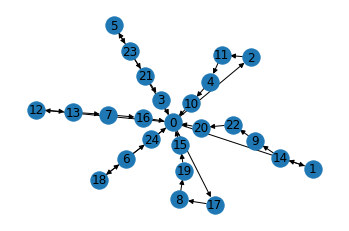

In [627]:
limits = plt.axis("off")
G = nx.DiGraph()
G.add_edges_from(aristasVRP[2])
nx.draw_networkx(G)
plt.show()

#### CVRP

##### Carga

In [628]:
aristasCVRP = np.load("Dataset/Targets/CVRP/aristas.npy")
distanciasCVRP = np.load("Dataset/Targets/CVRP/distancias.npy")
cargasCVRP = np.load("Dataset/Targets/CVRP/cargas.npy")

##### Cantidad

In [629]:
aristasCVRP.shape[0]

10000

##### Cantidad de problemas sin solución

In [630]:
ls = []
for i in range(aristasCVRP.shape[0]):
   if(not all((aristasCVRP[i] == np.zeros((30, 3))).tolist())):
      ls.append(i)
len(ls)

0

#### Ejemplo

Grafo solución de una instancia

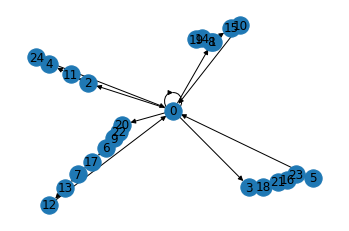

In [631]:
limits = plt.axis("off")
G = nx.DiGraph()
G.add_weighted_edges_from(aristasCVRP[2])
nx.draw_networkx(G)
plt.show()

## Modelos

### Feed-Forward Neural Network

#### Tratamiento de datos

Partición del dataset en train y test

##### VRP

In [632]:
X_VRP = np.array([np.concatenate((matrices[i], vecNumVehiculos), axis=1) 
                  for i in range(numInstancias)])
y_VRP = np.array([matrizAdyacenciaVRP(ari)
                  for ari in aristasVRP])

X_trainVRP, X_testVRP, y_trainVRP, y_testVRP = train_test_split(X_VRP, y_VRP, test_size=0.25, random_state=1)

dimensionX_VRP = X_trainVRP[0].shape[0]*X_trainVRP[0].shape[1]
dimensiony_VRP = y_trainVRP[0].shape[0]*y_trainVRP[0].shape[1]

##### CVRP

In [633]:
X_CVRP = np.array([np.concatenate((matrices[i], vecNumVehiculos, demandas[i].reshape((l, 1)), vecCapacidades[i]), axis=1) 
                  for i in range(numInstancias)])
y_CVRP = np.array([matrizAdyacenciaCVRP(ari)
                  for ari in aristasCVRP])

X_trainCVRP, X_testCVRP, y_trainCVRP, y_testCVRP = train_test_split(X_CVRP, y_CVRP, test_size=0.25, random_state=1)

dimensionX_CVRP = X_trainCVRP[0].shape[0]*X_trainCVRP[0].shape[1]
dimensiony_CVRP = y_trainCVRP[0].shape[0]*y_trainCVRP[0].shape[1]

#### Crear Dataset especifico para el modelo

Creación de la clase Dataset para la manipulación de los datos

In [634]:
class Dataset(torch.utils.data.Dataset):
   def __init__(self, X, y):
      self.X = torch.from_numpy(X).float().cuda().view(-1, X[0].shape[0]*X[0].shape[1])
      self.y = torch.from_numpy(y).float().cuda().view(-1, y[0].shape[0]*y[0].shape[1])
   def __len__(self):
      return len(self.X)
   def __getitem__(self, ix):
      return self.X[ix], self.y[ix]

datasetVRP = {
   'train': Dataset(X_trainVRP, y_trainVRP),
   'test': Dataset(X_testVRP, y_testVRP),
}

datasetCVRP = {
   'train': Dataset(X_trainCVRP, y_trainCVRP),
   'test': Dataset(X_testCVRP, y_testCVRP),
}

Se divide el dataset en batches para un mejor entrenamiento usando el modulo utils.data.

In [635]:
dataloaderVRP = {
   'train': torch.utils.data.DataLoader(datasetVRP['train'], batch_size=100, shuffle=True),
   'test': torch.utils.data.DataLoader(datasetVRP['test'], batch_size=250, shuffle=False)
}

dataloaderCVRP = {
   'train': torch.utils.data.DataLoader(datasetCVRP['train'], batch_size=100, shuffle=True),
   'test': torch.utils.data.DataLoader(datasetCVRP['test'], batch_size=250, shuffle=False)
}

#### Definición del modelo

In [636]:
class FFNN(torch.nn.Module):
   def __init__(self, D_in, H, D_out):
      super().__init__()
      self.fc1 = torch.nn.Sequential(
                    torch.nn.Linear(D_in, H),
                    torch.nn.ReLU()
                 )
      self.fc2 = torch.nn.Sequential(
                    torch.nn.Linear(H, 2*H),
                    torch.nn.ReLU()
                 )
      self.fc3 = torch.nn.Sequential(
                    torch.nn.Linear(2*H, H),
                    torch.nn.ReLU()
                 )
      self.fc4 = torch.nn.Sequential(
                    torch.nn.Linear(H, D_out),
                    torch.nn.Hardsigmoid()
                 )
   
   def forward(self, x):
      x = self.fc1(x)
      x = self.fc2(x)
      x = self.fc3(x)
      x = self.fc4(x)
      return x

#### Función de entrenamiento

In [637]:
def fit(model, dataloader, epochs=5):
   model.to(device)
   optimizer = torch.optim.Adam(model.parameters(), lr=1e-2)
   criterion = torch.nn.KLDivLoss(reduction="batchmean", log_target=True)
   FFNNTrainLossMean, FFNNValLossMean, FFNNTrainAccMean, FFNNValAccMean = [0.0], [0.0], [0.0], [0.0]
   for epoch in range(1, epochs+1):
      model.train()
      FFNNTrainLoss, FFNNTrainAcc = [], []
      batches = dataloader['train']
      for batch in batches:
         X, y = batch
         X, y = X.to(device), y.to(device)
         optimizer.zero_grad()
         y_hat = model(X)
         loss = criterion(y_hat, torch.nn.functional.softmax(y, dim=1))
         loss.backward()
         optimizer.step()
         FFNNTrainLoss.append(loss.item())
         acc = (y == y_hat).all(axis=1).sum() / len(y)
         FFNNTrainAcc.append(acc.to("cpu"))
      batches = dataloader['test']
      FFNNValLoss, FFNNValAcc = [], []
      model.eval()
      with torch.no_grad():
         for batch in batches:
            X, y = batch
            X, y = X.to(device), y.to(device)
            y_hat = model(X)
            loss = criterion(y_hat, torch.nn.functional.softmax(y, dim=1))
            FFNNValLoss.append(loss.item())
            acc = (y == y_hat).all(axis=1).sum() / len(y)
            FFNNValAcc.append(acc.to("cpu"))
      FFNNTrainLossMean.append(np.mean(FFNNTrainLoss))
      FFNNValLossMean.append(np.mean(FFNNValLoss))
      FFNNTrainAccMean.append(np.mean(FFNNTrainAcc))
      FFNNValAccMean.append(np.mean(FFNNValAcc))
      print(f"Epoch {epoch}/{epochs} loss {np.mean(FFNNTrainLoss):.5f} val_loss {np.mean(FFNNValLoss):.5f} acc {np.mean(FFNNTrainAcc):.5f} val_acc {np.mean(FFNNValAcc):.5f}")
   return FFNNTrainLossMean, FFNNValLossMean, FFNNTrainAccMean, FFNNValAccMean

#### VRP

##### Instanciación del modelo

In [638]:
FFNN_VRPmodel = FFNN(dimensionX_VRP, 100, dimensiony_VRP)
FFNN_VRPmodel

FFNN(
  (fc1): Sequential(
    (0): Linear(in_features=650, out_features=100, bias=True)
    (1): ReLU()
  )
  (fc2): Sequential(
    (0): Linear(in_features=100, out_features=200, bias=True)
    (1): ReLU()
  )
  (fc3): Sequential(
    (0): Linear(in_features=200, out_features=100, bias=True)
    (1): ReLU()
  )
  (fc4): Sequential(
    (0): Linear(in_features=100, out_features=625, bias=True)
    (1): Hardsigmoid()
  )
)

##### Entrenamiento

In [639]:
epochs = 25

FFNNTrainLossVRP, FFNNValLossVRP, FFNNTrainAccVRP, FFNNValAccVRP = fit(FFNN_VRPmodel,
                                                                       dataloaderVRP,
                                                                       epochs=epochs)

Epoch 1/25 loss -492.13263 val_loss -495.79333 acc 0.00000 val_acc 0.00000
Epoch 2/25 loss -495.83333 val_loss -495.79332 acc 0.00000 val_acc 0.00000
Epoch 3/25 loss -495.79326 val_loss -495.79332 acc 0.00000 val_acc 0.00000
Epoch 4/25 loss -495.79327 val_loss -495.79332 acc 0.00000 val_acc 0.00000
Epoch 5/25 loss -495.79327 val_loss -495.79332 acc 0.00000 val_acc 0.00000
Epoch 6/25 loss -495.79326 val_loss -495.79332 acc 0.00000 val_acc 0.00000
Epoch 7/25 loss -495.79326 val_loss -495.79332 acc 0.00000 val_acc 0.00000
Epoch 8/25 loss -495.79327 val_loss -495.79332 acc 0.00000 val_acc 0.00000
Epoch 9/25 loss -495.79327 val_loss -495.79332 acc 0.00000 val_acc 0.00000
Epoch 10/25 loss -495.79327 val_loss -495.79332 acc 0.00000 val_acc 0.00000
Epoch 11/25 loss -495.79327 val_loss -495.79332 acc 0.00000 val_acc 0.00000
Epoch 12/25 loss -495.79326 val_loss -495.79332 acc 0.00000 val_acc 0.00000
Epoch 13/25 loss -495.79327 val_loss -495.79332 acc 0.00000 val_acc 0.00000
Epoch 14/25 loss -495

##### Gráficas de métricas

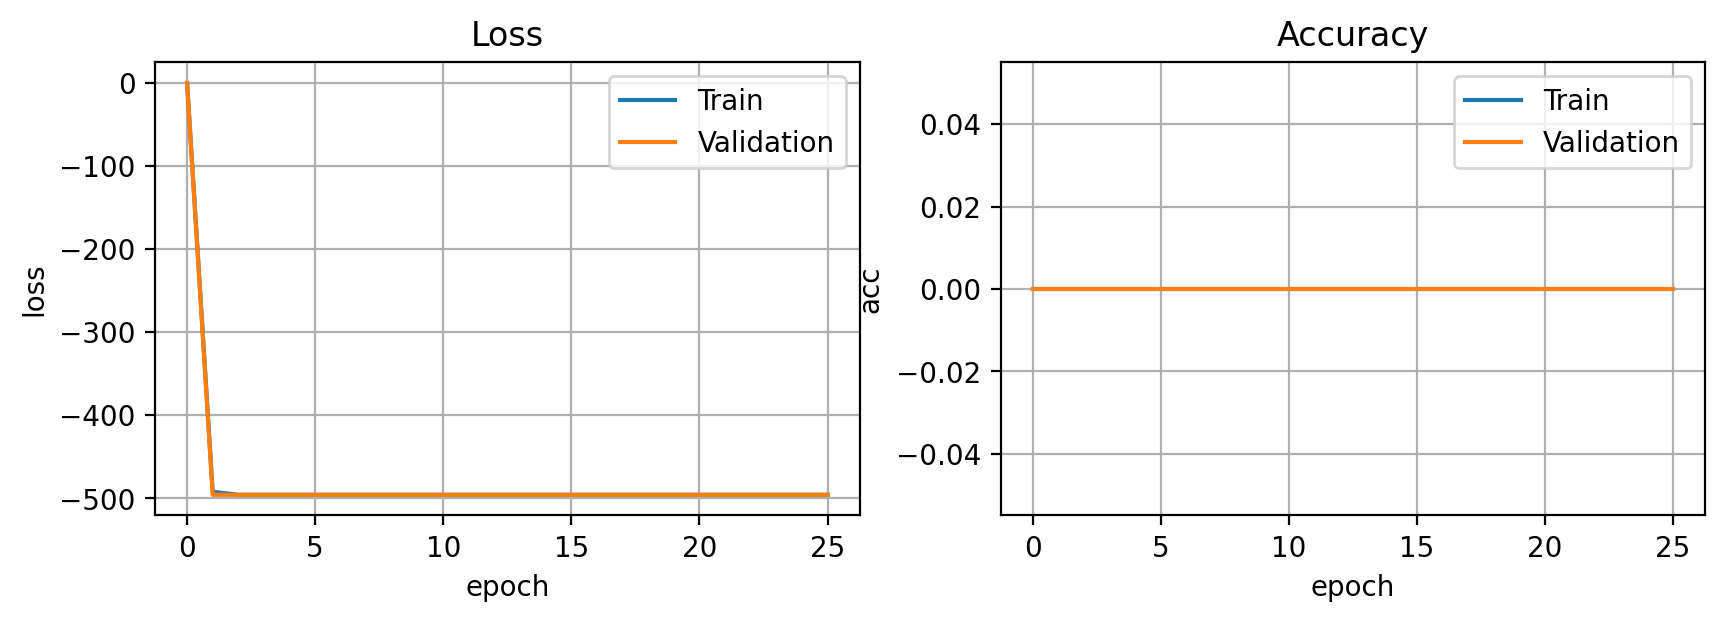

In [640]:
fig = plt.figure(dpi=200, figsize=(10,3))
ax = plt.subplot(121)
ax.plot(FFNNTrainLossVRP, label="Train")
ax.plot(FFNNValLossVRP, label="Validation")
ax.legend()
ax.grid(True)
ax.set_title('Loss')
ax.set_xlabel('epoch')
ax.set_ylabel('loss')
ax = plt.subplot(122)
ax.plot(FFNNTrainAccVRP, label="Train")
ax.plot(FFNNValAccVRP, label="Validation")
ax.legend()
ax.grid(True)
ax.set_title('Accuracy')
ax.set_ylabel('acc')
ax.set_xlabel('epoch')
plt.show()

##### Guardando el modelo

In [641]:
torch.save(FFNN_VRPmodel.state_dict(), "Models/VRP/FFNN.pt")

#### CVRP

##### Instanciación del modelo

In [642]:
FFNN_CVRPmodel = FFNN(dimensionX_CVRP, 100, dimensiony_CVRP)
FFNN_CVRPmodel

FFNN(
  (fc1): Sequential(
    (0): Linear(in_features=825, out_features=100, bias=True)
    (1): ReLU()
  )
  (fc2): Sequential(
    (0): Linear(in_features=100, out_features=200, bias=True)
    (1): ReLU()
  )
  (fc3): Sequential(
    (0): Linear(in_features=200, out_features=100, bias=True)
    (1): ReLU()
  )
  (fc4): Sequential(
    (0): Linear(in_features=100, out_features=625, bias=True)
    (1): Hardsigmoid()
  )
)

##### Entrenamiento

In [643]:
epochs = 25

FFNNTrainLossCVRP, FFNNValLossCVRP, FFNNTrainAccCVRP, FFNNValAccCVRP = fit(FFNN_CVRPmodel,
                                                                           dataloaderCVRP,
                                                                           epochs=epochs)

Epoch 1/25 loss -477.37294 val_loss -481.71451 acc 0.00000 val_acc 0.00000
Epoch 2/25 loss -483.25590 val_loss -482.72338 acc 0.00000 val_acc 0.00000
Epoch 3/25 loss -484.80412 val_loss -483.72476 acc 0.00000 val_acc 0.00000
Epoch 4/25 loss -483.77574 val_loss -483.72489 acc 0.00000 val_acc 0.00000
Epoch 5/25 loss -483.72222 val_loss -483.72489 acc 0.00000 val_acc 0.00000
Epoch 6/25 loss -483.72222 val_loss -483.72489 acc 0.00000 val_acc 0.00000
Epoch 7/25 loss -483.72222 val_loss -483.72489 acc 0.00000 val_acc 0.00000
Epoch 8/25 loss -483.72222 val_loss -483.72489 acc 0.00000 val_acc 0.00000
Epoch 9/25 loss -483.72222 val_loss -483.72489 acc 0.00000 val_acc 0.00000
Epoch 10/25 loss -483.72222 val_loss -483.72489 acc 0.00000 val_acc 0.00000
Epoch 11/25 loss -483.72222 val_loss -483.72489 acc 0.00000 val_acc 0.00000
Epoch 12/25 loss -483.72222 val_loss -483.72489 acc 0.00000 val_acc 0.00000
Epoch 13/25 loss -483.72222 val_loss -483.72489 acc 0.00000 val_acc 0.00000
Epoch 14/25 loss -483

##### Gráficas de métricas

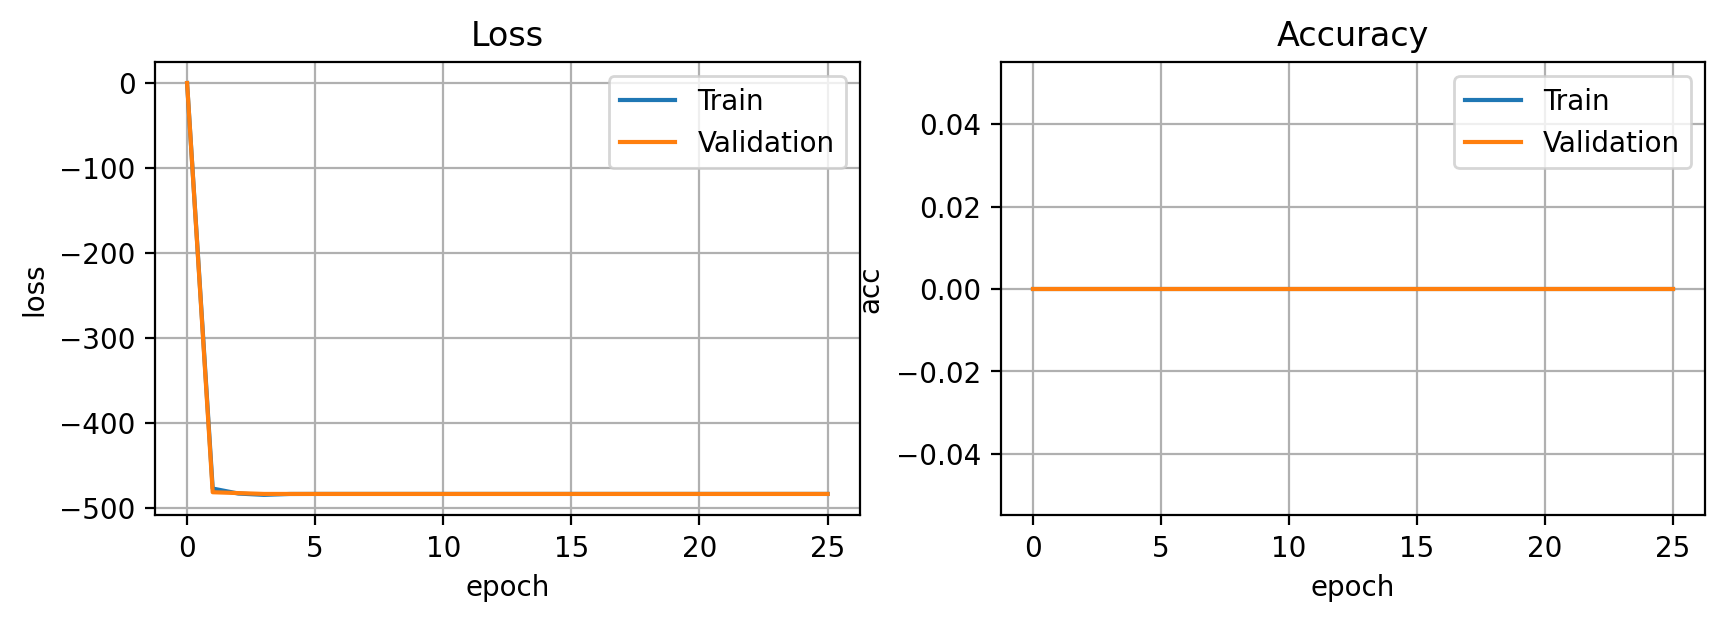

In [644]:
fig = plt.figure(dpi=200, figsize=(10,3))
ax = plt.subplot(121)
ax.plot(FFNNTrainLossCVRP, label="Train")
ax.plot(FFNNValLossCVRP, label="Validation")
ax.legend()
ax.grid(True)
ax.set_title('Loss')
ax.set_xlabel('epoch')
ax.set_ylabel('loss')
ax = plt.subplot(122)
ax.plot(FFNNTrainAccCVRP, label="Train")
ax.plot(FFNNValAccCVRP, label="Validation")
ax.legend()
ax.grid(True)
ax.set_title('Accuracy')
ax.set_ylabel('acc')
ax.set_xlabel('epoch')
plt.show()

##### Guardando el modelo

In [645]:
torch.save(FFNN_CVRPmodel.state_dict(), "Models/CVRP/FFNN.pt")